In [2]:
from models.backbone_R2U_Net import build_backbone
from models.TopDiG import build_TopDiG
from dataloader_cocostyle import image_graph_collate_road_network_coco, min_max_normalize, CrowdAI

from PIL import Image
from skimage.transform import resize
import matplotlib.pyplot as plt
import yaml
import json
import torch
import numpy as np

class obj:
    def __init__(self, dict1):
        self.__dict__.update(dict1)
        
def dict2obj(dict1):
    return json.loads(json.dumps(dict1), object_hook=obj)

### Inria cocostyle GT 예시

loading annotations into memory...
Done (t=0.17s)
creating index...
index created!
Built Dataset Options:
--Num.of images: 1355
--Gap Distance: 10 --Sigma: 1.0 --nms: False
torch.Size([6, 3, 320, 320])


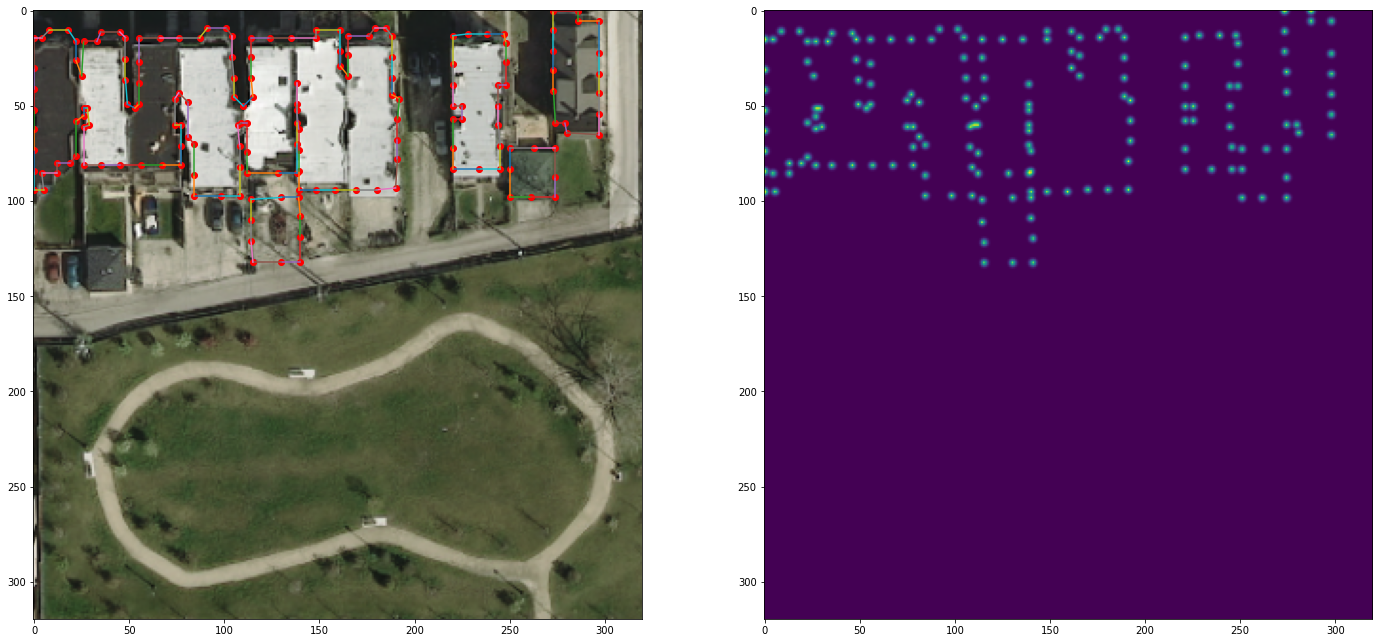

In [3]:
dataset = CrowdAI(images_directory='/nas/k8s/dev/research/doyoungi/dataset/Inria_building/cocostyle_inria_test/images',
                    annotations_path='/nas/k8s/dev/research/doyoungi/dataset/Inria_building/cocostyle_inria_test/annotation.json',)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=6, collate_fn=image_graph_collate_road_network_coco, shuffle=False)

print(next(iter(dataloader))[0].shape) # image

data = next(iter(dataloader))

# 6개의 이미지 중 1번째 GT
image = data[0][1].detach().cpu().numpy().transpose(1,2,0)
heatmap =  data[1][1].detach().cpu().numpy()
nodes = data[2][1].detach().cpu().numpy() * image.shape[0]
edges = data[3][1].detach().cpu().numpy()

gt_nodes = nodes.astype('int64')

# Visualize
fig, ax = plt.subplots(1, 2, figsize=(24, 12))
ax[0].imshow(min_max_normalize(image, 0))
ax[0].scatter(gt_nodes[:,1], gt_nodes[:,0], color='r')

for e in edges:
    connect = np.stack([gt_nodes[e[0]], gt_nodes[e[1]]], axis=0)
    ax[0].plot(connect[:,1], connect[:,0])

ax[1].imshow(heatmap[0])
plt.show()

In [3]:
device = 'cuda'
images = torch.zeros((6,3,320,320)).to(device)
for i, image in enumerate(data[0]):
    image = resize(image, (3, 320, 320), anti_aliasing=True, preserve_range=True)
    images[i] = torch.tensor(image).to(device)

R2U-Net 모델에 ckpt 로드하여 NMS 결과 시각화

In [6]:
!ls work_dirs/R2U_Net_pretrain/runs/baseline_R2U_Net_pretrain_epoch200_5e-6_10_0.7_control_10/models

epochs_10.pth	epochs_20.pth  epochs_40.pth  epochs_60.pth  epochs_80.pth
epochs_100.pth	epochs_30.pth  epochs_50.pth  epochs_70.pth  epochs_90.pth


tensor([-15.1434, -14.7724, -14.7692,  ...,   5.0512,   5.0745,   5.1286],
       device='cuda:0')


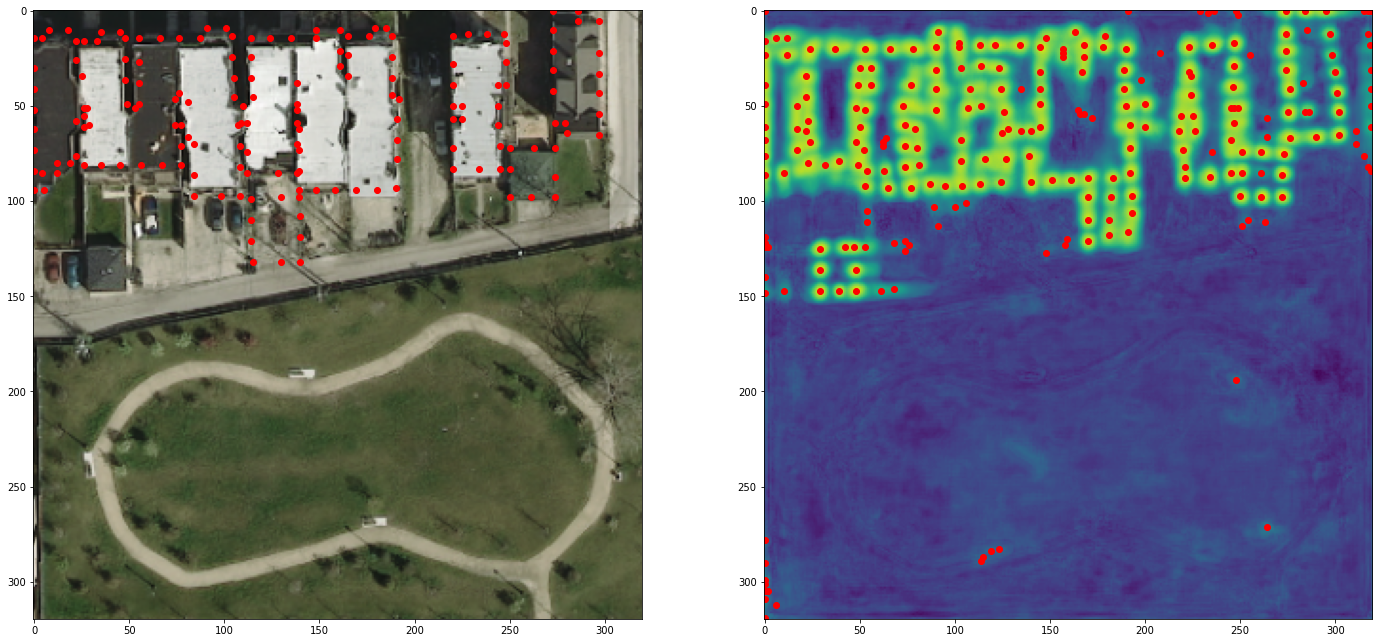

In [17]:
config2 = 'configs/pretrain/pretrain_10_0.7.yaml'
# ckpt_backbone_path = 'work_dirs/R2U_Net_pretrain/runs/baseline_R2U_Net_pretrain_epoch60_5e-6_10_0.7_10/models/epochs_50.pth'
# ckpt_backbone_path = "/nas/k8s/dev/research/intern/tsgil/relationformer/work_dirs/R2U_Net_pretrain/runs/baseline_R2U_Net_pretrain_epoch200_5e-6_10/models/epochs_100.pth"
# ckpt_backbone_path = "work_dirs/R2U_Net_pretrain/runs/baseline_R2U_Net_pretrain_epoch200_5e-6_10_0.7_control_10/models/epochs_100.pth"
# ckpt_backbone_path = "work_dirs/R2U_Net_pretrain/runs/baseline_R2U_Net_pretrain_epoch200_5e-6_10_1.0_control_10/models/epochs_100.pth"
ckpt_backbone_path = "work_dirs/R2U_Net_pretrain/runs/baseline_R2U_Net_pretrain_epoch200_5e-6_10_1.0_batch8_cocoinria_nms_10/models/epochs_100.pth"

R2U = build_backbone(config2).to(device)
ckpt = torch.load(ckpt_backbone_path, map_location='cpu')
R2U.load_state_dict(ckpt['model_state_dict'])
# R2U.eval()
R2U.train()
with torch.no_grad():
    ftm_R2U, htm_R2U, nms_R2U = R2U(images)
print(htm_R2U[1].unique())
image = images[1].detach().cpu().numpy().transpose(1,2,0)
nodes = nms_R2U[1][1].detach().cpu().numpy()
htm = htm_R2U[1].detach().cpu().numpy()[0]


# Visualize
fig, ax = plt.subplots(1,2, figsize=(24, 12))
ax[0].imshow(min_max_normalize(image, 0))
ax[1].scatter(nodes[:,1], nodes[:,0], color='r')
ax[1].imshow(htm)
ax[0].scatter(gt_nodes[:,1], gt_nodes[:,0], color='r')
plt.show()

tensor([-20.5074, -20.2814, -20.2210,  ...,   4.4510,   4.4732,   4.4915],
       device='cuda:0')


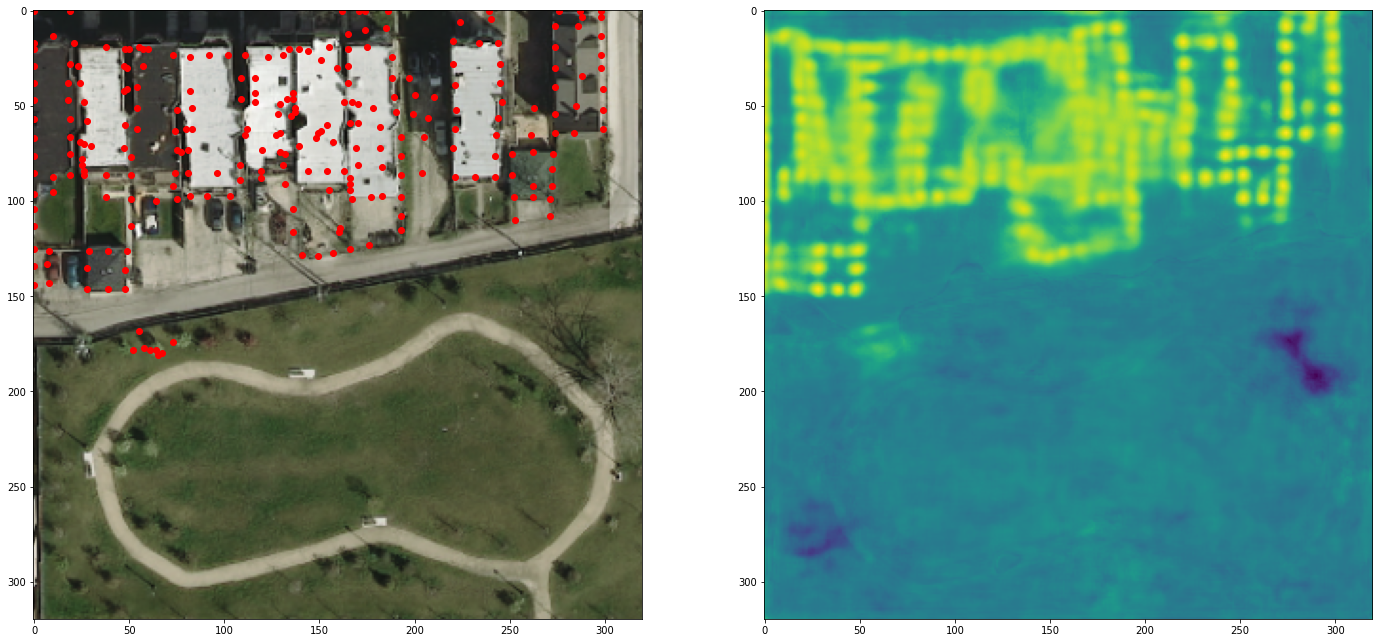

In [9]:
config2 = 'configs/pretrain/pretrain_10_0.7.yaml'
# ckpt_backbone_path = 'work_dirs/R2U_Net_pretrain/runs/baseline_R2U_Net_pretrain_epoch60_5e-6_10_1.0_10/models/epochs_40.pth'
# ckpt_backbone_path = "/nas/k8s/dev/research/intern/tsgil/relationformer/work_dirs/R2U_Net_pretrain/runs/baseline_R2U_Net_pretrain_epoch200_5e-6_10/models/epochs_60.pth"
# ckpt_backbone_path = "work_dirs/R2U_Net_pretrain/runs/baseline_R2U_Net_pretrain_epoch200_5e-6_10_1.0_control_10/models/epochs_50.pth"
ckpt_backbone_path = "work_dirs/R2U_Net_pretrain/runs/baseline_R2U_Net_pretrain_epoch200_5e-6_10_0.7_control_10/models/epochs_60.pth"
device = 'cuda'
R2U = build_backbone(config2).to(device)
ckpt = torch.load(ckpt_backbone_path, map_location='cpu')
R2U.load_state_dict(ckpt['model_state_dict'])
# R2U.eval()
R2U.train()
with torch.no_grad():
    ftm_R2U, htm_R2U, nms_R2U = R2U(images)
print(htm_R2U[1].unique())
image = images[1].detach().cpu().numpy().transpose(1,2,0)
nodes = nms_R2U[1][1].detach().cpu().numpy()
htm = htm_R2U[1].detach().cpu().numpy()[0]


# Visualize
fig, ax = plt.subplots(1,2, figsize=(24, 12))
ax[0].imshow(min_max_normalize(image, 0))
ax[0].scatter(nodes[:,1], nodes[:,0], color='r')
ax[1].imshow(htm)
plt.show()

TopDiG, 백본 ckpt 불러오기

In [11]:
# config_file = "configs/topdig/topdig_10_1.0_inria_diag.yaml"
# config_file2 = "configs/pretrain/pretrain_10_1.0_inria.yaml"
# ckpt_backbone_path = "work_dirs/R2U_Net_pretrain/runs/baseline_R2U_Net_pretrain_epoch200_5e-6_10_1.0_batch8_cocoinria_nms_10/models/epochs_120.pth"
# ckpt_path = "work_dirs/TopDiG_train/runs/baseline_TopDiG_train_epoch20_topdig_10_1.0_inria_sinkhorn_diag_10/models/epochs_20.pth"

# config_file = "configs/topdig/topdig_10_1.0_control_diag.yaml"
# config_file2 = "configs/pretrain/pretrain_10_1.0_control.yaml"
# ckpt_backbone_path = "work_dirs/R2U_Net_pretrain/runs/baseline_R2U_Net_pretrain_epoch200_5e-6_10_1.0_control_10/models/epochs_120.pth"
# ckpt_path = "work_dirs/TopDiG_train/runs/baseline_TopDiG_train_epoch20_topdig_10_1.0_control_sinkhorn_diag_10/models/epochs_20.pth"

config_file = "configs/topdig/topdig_10_0.7_control_diag.yaml"
config_file2 = "configs/pretrain/pretrain_10_0.7_control.yaml"
ckpt_backbone_path = "work_dirs/R2U_Net_pretrain/runs/baseline_R2U_Net_pretrain_epoch200_5e-6_10_0.7_control_10/models/epochs_100.pth"
ckpt_path = "work_dirs/TopDiG_train/runs/baseline_TopDiG_train_epoch20_topdig_10_0.7_control_sinkhorn_diag_10/models/epochs_20.pth"

with open(config_file) as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
config = dict2obj(config)

with open(config_file2) as f:
    config2 = yaml.load(f, Loader=yaml.FullLoader)
config2 = dict2obj(config2)

model = build_TopDiG(config) # 빌드 함수 내부에서 ckpt 파일 로드함

checkpoint = torch.load(ckpt_backbone_path, map_location='cpu')
print(checkpoint['model_state_dict'].keys())
print(model.state_dict().keys())

checkpoint2 = torch.load(ckpt_path, map_location='cpu')
missing_keys, unexpected_keys = model.load_state_dict(checkpoint2['model_state_dict'], strict=False) # 여기서 TopDiG 학습한 체크포인트 로드
unexpected_keys = [k for k in unexpected_keys if not (k.endswith('total_params') or k.endswith('total_ops'))]
if len(missing_keys) > 0:
    print('Missing Keys: {}'.format(missing_keys))
if len(unexpected_keys) > 0:
    print('Unexpected Keys: {}'.format(unexpected_keys))
# model.eval()
device = torch.device("cuda")
# device = torch.device("cpu")
model = model.to(device)

odict_keys(['encoder.RRCNN1.RCNN.0.conv.0.weight', 'encoder.RRCNN1.RCNN.0.conv.0.bias', 'encoder.RRCNN1.RCNN.0.conv.1.weight', 'encoder.RRCNN1.RCNN.0.conv.1.bias', 'encoder.RRCNN1.RCNN.0.conv.1.running_mean', 'encoder.RRCNN1.RCNN.0.conv.1.running_var', 'encoder.RRCNN1.RCNN.0.conv.1.num_batches_tracked', 'encoder.RRCNN1.RCNN.1.conv.0.weight', 'encoder.RRCNN1.RCNN.1.conv.0.bias', 'encoder.RRCNN1.RCNN.1.conv.1.weight', 'encoder.RRCNN1.RCNN.1.conv.1.bias', 'encoder.RRCNN1.RCNN.1.conv.1.running_mean', 'encoder.RRCNN1.RCNN.1.conv.1.running_var', 'encoder.RRCNN1.RCNN.1.conv.1.num_batches_tracked', 'encoder.RRCNN1.Conv_1x1.weight', 'encoder.RRCNN1.Conv_1x1.bias', 'encoder.RRCNN2.RCNN.0.conv.0.weight', 'encoder.RRCNN2.RCNN.0.conv.0.bias', 'encoder.RRCNN2.RCNN.0.conv.1.weight', 'encoder.RRCNN2.RCNN.0.conv.1.bias', 'encoder.RRCNN2.RCNN.0.conv.1.running_mean', 'encoder.RRCNN2.RCNN.0.conv.1.running_var', 'encoder.RRCNN2.RCNN.0.conv.1.num_batches_tracked', 'encoder.RRCNN2.RCNN.1.conv.0.weight', 'enc

matcher로 256개의 노드에 대한 엣지 뽑기 테스트

In [12]:
images = torch.zeros((6,3,320,320)).to(device)
for i, image in enumerate(data[0]):
    image = resize(image, (3, 320, 320), anti_aliasing=True, preserve_range=True)
    images[i] = torch.tensor(image).to(device)
with torch.no_grad():
    out = model(images)
scores1, scores2 = out['scores1'], out['scores2']
htm_TopDiG, nms_TopDiG = out['pred_heatmaps'], (out['pred_nodes']*320)
nms_TopDiG = nms_TopDiG.type(torch.int)
print(htm_TopDiG[1].unique())
print(nms_TopDiG[1][:10])

tensor([-22.0332, -21.9170, -21.8473,  ...,   5.1967,   5.5027,   5.5144],
       device='cuda:0')
tensor([[ 67,   0],
        [ 77,   0],
        [ 27,   0],
        [ 63, 274],
        [ 16,   0],
        [ 98,   0],
        [  9, 275],
        [ 85, 251],
        [ 19, 275],
        [ 74, 261]], device='cuda:0', dtype=torch.int32)


In [13]:
from scipy.optimize import linear_sum_assignment # Scipy에 구현된 헝가리안 알고리즘 사용

def scores_to_permutations(scores): # 인퍼런스용 함수
    """
    Input a batched array of scores and returns the hungarian optimized 
    permutation matrices.
    """
    B, N, N = scores.shape

    scores = scores.detach().cpu().numpy()
    perm = np.zeros_like(scores)
    for b in range(B):
        # sinkhorn 알고리즘은 비공개된 트레인 파일에 있을 듯
        # 반복적인 노멀라이제이션(100번)을 위해 싱크홀 알고리즘 사용
        # 인퍼런스시에 헝가리안 알고리즘으로 linear sum assignment result 뽑는다
        r, c = linear_sum_assignment(-scores[b]) # 점수가 높을 수록 페어일 확률이 높으므로 -를 붙여서 최소 찾는 문제로 바꾼다.
        perm[b,r,c] = 1 # 헝가리안 알고리즘이 찾은 칸은 1로 아니면 0인 permutation matrix (B N N) 만든다
    return torch.tensor(perm) # 텐서로 바꿔주기

예측 노드 수: 256
선택된 예측 노드 수: 199
정답 노드 수: 170


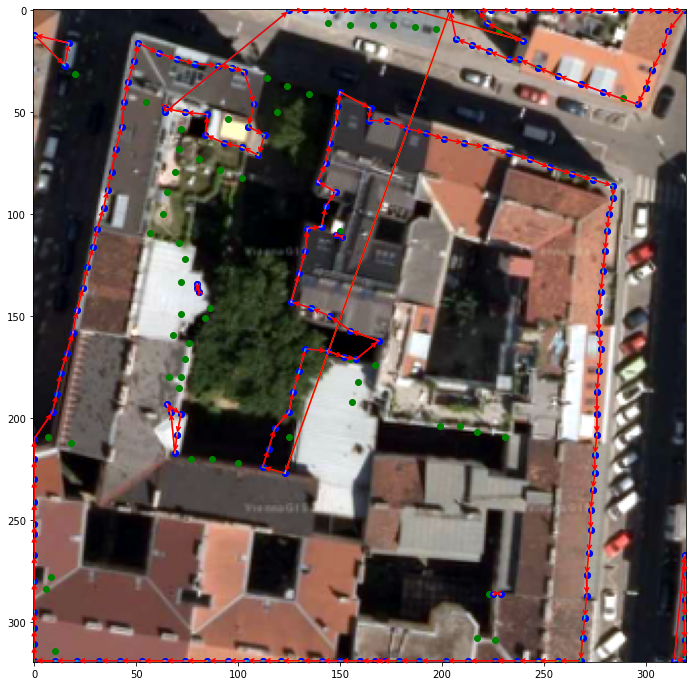

In [17]:
idx_of_batch = 4
scores = scores1.sigmoid() + scores2.transpose(1,2).sigmoid()

permu = scores_to_permutations(scores)
mat = permu[idx_of_batch].numpy()
edges = []
for i in range(len(mat)):
    for j in range(len(mat)):
        if mat[i][j] == 1:
            if i != j:
                edges.append((i,j))
nodes = nms_TopDiG[idx_of_batch].detach().cpu().numpy()
image = images[idx_of_batch].detach().cpu().numpy().transpose(1,2,0)

print("예측 노드 수:", len(nodes))
print("선택된 예측 노드 수:", len(edges))
print("정답 노드 수:", len(data[2][1].detach().cpu().numpy()))

# Visualize
plt.figure(figsize=(12,12))
plt.imshow(min_max_normalize(image, 0.5))
plt.scatter(nodes[:,1], nodes[:,0], color='g')
for x, _ in edges:
    plt.scatter(nodes[x][1], nodes[x][0], color='b')
for e in edges:
    connect = np.stack([nodes[e[0]], nodes[e[1]]], axis=0)
    plt.plot(connect[:,1], connect[:,0])
    plt.annotate("", xy=nodes[e[0]][::-1], xytext=nodes[e[1]][::-1], 
                arrowprops=dict(arrowstyle="->", lw=1.5, color='r'))

plt.show()

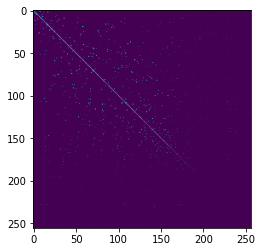

In [23]:
plt.imshow(scores1[1].sigmoid().cpu().numpy())

# for i in range(256):
#     print(scores1[1][i][i])

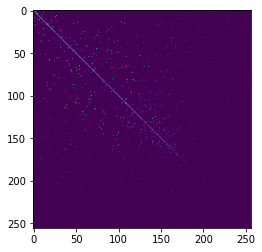

In [24]:
plt.imshow(scores2[1].sigmoid().cpu().numpy())